## temp, remove


In [1]:
import pandas as pd

In [2]:
#TODO clean this up
games_dfmap = {}
import os
def get_games_data(set_code: str):
    """Retrieves games data, prioritizing cached data, then Parquet, and finally CSV."""
    if set_code in games_dfmap:
        return games_dfmap[set_code]

    parquet_file = f"data/{set_code}/games.parquet"
    csv_file = f"data/{set_code}/games.csv"

    if os.path.exists(parquet_file):
        print(f"Loading game data for {set_code} from Parquet file...")
        #df = pd.read_parquet(parquet_file, engine="pyarrow")
        df = pd.read_parquet(parquet_file, engine='fastparquet')
        games_dfmap[set_code] = df
        return df

    if os.path.exists(csv_file):
        print(f"Reading and converting data for {set_code} to Parquet...")
        df = convert_to_parquet_(set_code)
        games_dfmap[set_code] = df
        return df
    
    raise FileNotFoundError(f"No data found (CSV or parquet) for set: {set_code}")
    
def convert_to_parquet_(set_code: str):
    """Converts the games CSV file to Parquet format for efficient storage and retrieval."""
    csv_file = f"data/{set_code}/games.csv"
    parquet_file = f"data/{set_code}/games.parquet"

    if os.path.exists(parquet_file):
        print(f"Parquet file {parquet_file} already exists. No conversion needed.")
        return games_dfmap.get(set_code, pd.read_parquet(parquet_file, engine="pyarrow"))

    if not os.path.exists(csv_file):
        raise FileNotFoundError(f"CSV file {csv_file} does not exist.")

    df = pd.read_csv(csv_file)
    df.to_parquet(parquet_file, engine="pyarrow", compression="snappy")  # Snappy is fast & efficient
    print(f"Converted {csv_file} to {parquet_file}.")
    
    games_dfmap[set_code] = df
    return df

In [3]:
games_df = get_games_data('blb')

Loading game data for blb from Parquet file...


In [38]:
file_path = f"data/blb/cards.csv"
print(f"Loading Scryfall data for blb from existing file...")
cards_df = pd.read_csv(file_path)


ratings_df = pd.read_csv("data/blb/card-ratings.csv")
ratings_df.head(2)

Loading Scryfall data for blb from existing file...


,Name,Color,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,OH WR,# GD,GD WR,# GIH,GIH WR,# GNS,GNS WR,IWD
0,Banishing Light,W,C,207601,3.17,53955,3.96,292583,89.4%,55.1%,48910,54.0%,67596,57.0%,116506,55.7%,175185,54.7%,1.0pp
1,"Beza, the Bounding Spring",W,M,7230,1.46,4829,1.43,26113,87.6%,57.1%,4508,62.2%,6233,62.7%,10741,62.5%,15368,53.3%,9.2pp


### 17Lands Data Field Descriptions  
(Compiled with assistance from Microsoft Copilot, edited)

- **Name**: The card's name.  
- **Color**: The card's primary color identity.  
- **Rarity**: The card's rarity (Common, Uncommon, Rare, Mythic).  
- **# Seen**: Total instances of the card appearing in draft packs.  
- **ALSA (Average Last Seen At)**: The average pick number where the card is still available. Lower values indicate highly desirable picks.  
- **ATA (Average Taken At)**: The average pick number where the card is actually taken. Typically lower than ALSA.  
- **# GP (Games Played)**: Count of games where the card was included in a deck.  
- **% GP (Percentage of Games Played)**: When drafted, the percentage of games where the card was present in the deck
- **GP WR (Games Played Win Rate)**: Win rate in games where the card was included in a deck.  
- **# OH (Opening Hand Count)**: Number of games where the card appeared in the opening hand.  
- **OH WR (Opening Hand Win Rate)**: Win rate when the card is present in the opening hand.  
- **# GD (Games Drawn Count)**: Number of games where the card was drawn naturally.  
- **GD WR (Games Drawn Win Rate)**: Win rate in games where the card was drawn.  
- **# GIH (Games In Hand Count)**: Total games where the card was in hand at any point, including opening hand, drawn, or tutored.  
- **GIH WR (Games In Hand Win Rate)**: Win rate for games where the card was in hand at least once.  
- **# GNS (Games Not Seen Count)**: Games where the card was in the deck but never appeared in hand.  
- **GNS WR (Games Not Seen Win Rate)**: Win rate for games where the card was never seen.  
- **IWD (Improvement When Drawn)**: Estimated improvement in win percentage when the card is drawn. Needs further verification.  

Opening hand refers to "final" opening hand after mulligans.

In [39]:
def curve_perturbation_score(curve: list):
    """Calculates a perturbation score for a given mana curve."""
    
    # Simple version
    # Curve comes in with a list of CMC counts with index 0 being CMC 0
    curve_min = [0, 1, 4, 3, 2, 0, 0]
    curve_max = [2, 4, 8, 7, 5, 4, 3] # These are very generous limits
    # We're attempting to account for the fact that if you have a lot of 2 CMC cards, you can afford to have fewer 3 CMC cards, and so on
    score = 0
    for i in range(7):
        if curve[i] < curve_min[i]:
            score += min(curve_min[i] - curve[i], 2) ** 2
        if curve[i] > curve_max[i]:
            score += min(curve[i] - curve_max[i], 2) ** 2
    return score

# Advantage: simple, generous limits - won't consider decks bad for slight variations
# Disadvantage: doesn't account for "neighbors"
# Really only finds decks that are pretty far outside the norm

def calc_removal_score():
    None


    

In [40]:
removal_file_path = "data/blb/removal.txt"
with open(removal_file_path, "r") as f:
    removal_cards = set(line.strip() for line in f)

# Filter the ratings DataFrame
removal_df = ratings_df[ratings_df["Name"].isin(removal_cards)][["Name", "Color", "Rarity", "ATA", "GP WR"]]
# Convert GP WR to float (removes '%' and converts to decimal format)
removal_df["GP WR"] = removal_df["GP WR"].str.rstrip('%').astype(float) / 100

# Display the resulting DataFrame
print(removal_df.head())

                   Name Color Rarity   ATA  GP WR
0       Banishing Light     W      C  3.96  0.551
10    Driftgloom Coyote     W      U  3.48  0.555
23         Parting Gust     W      U  5.38  0.534
26       Repel Calamity     W      U  4.76  0.554
33  Starfall Invocation     W      R  2.10  0.544


In [41]:
import pandas as pd

def filter_drafts(games_df: pd.DataFrame, num_drafts: int) -> pd.DataFrame:
    """
    Extracts N distinct drafts from games_df and retains only relevant columns.
    
    Parameters:
    games_df (pd.DataFrame): The dataframe containing game data.
    num_drafts (int): Number of distinct drafts to capture.
    
    Returns:
    pd.DataFrame: Filtered dataframe with only selected columns.
    """
    # Capture distinct draft IDs until we reach num_drafts
    selected_draft_ids = games_df["draft_id"].drop_duplicates().iloc[:num_drafts].tolist()
    
    # Filter dataframe to include only the selected drafts
    filtered_df = games_df[games_df["draft_id"].isin(selected_draft_ids)]
    
    # Identify columns to keep
    columns_to_keep = ["draft_id", "rank", "main_colors", "splash_colors", "won"] + [
        col for col in games_df.columns if col.startswith("deck_")
    ]
    
    # Drop all other columns
    filtered_df = filtered_df[columns_to_keep]
    
    return filtered_df

# Example usage:
selected_games_df = filter_drafts(games_df, num_drafts=500)

# Convert boolean values to integers (True = 1, False = 0)
selected_games_df["won"] = selected_games_df["won"].astype(int)

# Calculate wins and losses per draft ID
selected_games_df["wins"] = selected_games_df.groupby("draft_id")["won"].transform("sum")
selected_games_df["losses"] = selected_games_df.groupby("draft_id")["won"].transform("count") - selected_games_df["wins"]

selected_games_df = selected_games_df.drop_duplicates(subset=["draft_id"])

selected_games_df.head()


,draft_id,rank,main_colors,splash_colors,won,deck_Agate Assault,deck_Agate-Blade Assassin,deck_Alania's Pathmaker,"deck_Alania, Divergent Storm",deck_Artist's Talent,...,deck_Whiskerquill Scribe,deck_Whiskervale Forerunner,deck_Wick's Patrol,"deck_Wick, the Whorled Mind",deck_Wildfire Howl,deck_Wishing Well,"deck_Ygra, Eater of All","deck_Zoraline, Cosmos Caller",wins,losses
0,deaa4cdcd3e84d8e8b5a0ea34a0f9d79,gold,BG,WR,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,6,3
9,676ca08a6f5e49ae9aee978bd62c02b1,silver,UBG,WR,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,3
15,488a8410974649eb82add4b1a6f54a75,silver,BR,None,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,3,3
21,041c4197d49d4d5ea490cc10b0677822,silver,UG,W,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,3
27,41dafe993991494e9bbf2894af398d25,gold,WR,None,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,6,3


In [59]:
#TODO try excluding CMC > 4 or passing CMC values

def get_type_stats(selected_games_df, type_df):
    """
    Creates a dictionary of small DataFrames for each deck with card stats of a given type (e.g., removal, bombs).
    
    Parameters:
    selected_games_df (pd.DataFrame): The filtered drafts data.
    type_df (pd.DataFrame): The data frame containing cards of the specified type.
    type_name (str): The type of cards being processed (e.g., "removal", "bomb").
    
    Returns:
    dict: A dictionary where keys are draft IDs and values are DataFrames with stats for the given type.
    """
    type_stats = {}

    for draft_id in selected_games_df["draft_id"]:
        # Get cards in the current deck
        deck_cards = selected_games_df[selected_games_df["draft_id"] == draft_id].iloc[0]

        # Extract relevant cards and their counts
        type_cards_in_deck = {
            card: deck_cards[f"deck_{card}"] 
            for card in type_df["Name"] 
            if f"deck_{card}" in selected_games_df.columns and deck_cards[f"deck_{card}"] > 0
        }

        # Create DataFrame for this draft
        df = pd.DataFrame([
            {"card name": card, "count": count, "GP WR": type_df.loc[type_df["Name"] == card, "GP WR"].values[0]}
            for card, count in type_cards_in_deck.items()
        ])

        type_stats[draft_id] = df

    return type_stats

# Example usage:
removal_tables = get_type_stats(selected_games_df, removal_df)

removal_tables["deaa4cdcd3e84d8e8b5a0ea34a0f9d79"]

,card name,count,GP WR
0,Savor,2,0.564
1,Polliwallop,1,0.550


In [43]:
def calc_removal_score(removal_table):
    """
    Calculates a removal score for a given removal table. If the table is empty, returns 0.
    
    Parameters:
    removal_table (pd.DataFrame): DataFrame containing removal cards and their stats.
    
    Returns:
    float: Total removal score for the deck.
    """
    if removal_table.empty:
        return 0
    return (removal_table["count"] * (removal_table["GP WR"] - 0.52)).sum()

# Calculate removal score for each draft and add it to selected_games_df
selected_games_df["removal_score"] = selected_games_df["draft_id"].map(lambda draft_id: calc_removal_score(removal_tables.get(draft_id, pd.DataFrame())))

# Print selected games DataFrame with only specified columns
print(selected_games_df[["draft_id", "wins", "losses", "removal_score"]])


                              draft_id  wins  losses  removal_score
0     deaa4cdcd3e84d8e8b5a0ea34a0f9d79     6       3          0.118
9     676ca08a6f5e49ae9aee978bd62c02b1     3       3          0.073
15    488a8410974649eb82add4b1a6f54a75     3       3          0.247
21    041c4197d49d4d5ea490cc10b0677822     3       3          0.006
27    41dafe993991494e9bbf2894af398d25     6       3          0.031
...                                ...   ...     ...            ...
2880  9e4e65ea61cd44359f5bc84a7e86c566     4       3          0.049
2887  bcaeba5e109c4eb590e3b02656f3edbf     3       3          0.092
2893  f3eff5ec4da2463686a2ef9395be354f     2       3          0.032
2898  a126fff5d5694c6a94cbbef374219a8f     3       2          0.002
2903  23ed19011b724740990717950e552080     0       3          0.032

[500 rows x 4 columns]


In [44]:
removal_df[removal_df["GP WR"] < 0.535].sort_values("GP WR", ascending=False).head(10)

,Name,Color,Rarity,ATA,GP WR
23,Parting Gust,W,U,5.38,0.534
71,Spellgyre,U,U,8.20,0.532
75,Sugar Coat,U,U,6.57,0.531
44,Dazzling Denial,U,C,9.31,0.530
92,Early Winter,B,C,8.52,0.527
66,Run Away Together,U,C,9.86,0.523
243,Bumbleflower's Sharepot,NaN,C,9.63,0.522
57,Long River's Pull,U,U,8.91,0.519
160,Wildfire Howl,R,U,8.57,0.519
130,Conduct Electricity,R,C,9.97,0.517


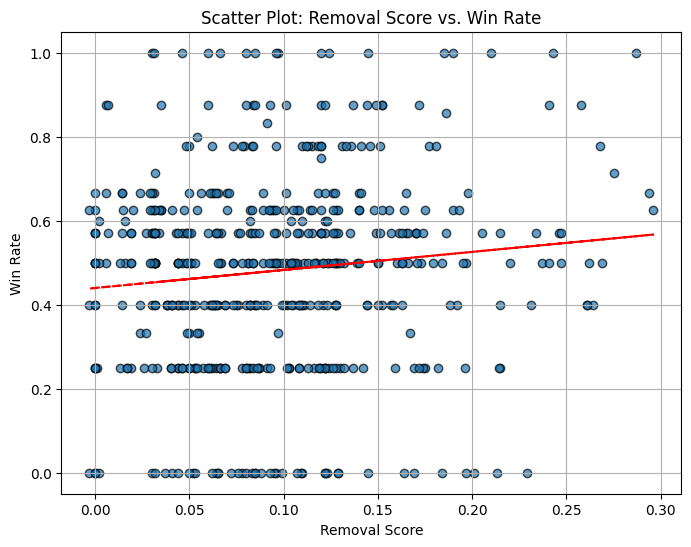

In [45]:
import matplotlib.pyplot as plt
import numpy as np
# Calculate win rate
selected_games_df["win_rate"] = selected_games_df["wins"] / (selected_games_df["wins"] + selected_games_df["losses"])

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(selected_games_df["removal_score"], selected_games_df["win_rate"], alpha=0.7, edgecolors="black")

# Labels and title
plt.xlabel("Removal Score")
plt.ylabel("Win Rate")
plt.title("Scatter Plot: Removal Score vs. Win Rate")
plt.grid(True)
m, b = np.polyfit(selected_games_df["removal_score"], selected_games_df["win_rate"], 1)
plt.plot(selected_games_df["removal_score"], m * selected_games_df["removal_score"] + b, color="red", linestyle="dashed")
# Show plot
plt.show()


In [46]:
from scipy.stats import pearsonr

# Calculate Pearson correlation coefficient
corr, p_value = pearsonr(selected_games_df["removal_score"], selected_games_df["win_rate"])

# Print results
print(f"Pearson Correlation: {corr:.4f}")
print(f"P-Value: {p_value:.4f}")


Pearson Correlation: 0.1118
P-Value: 0.0124


In [47]:
def removal_score_53floor(removal_table):
    """
    Calculates removal score using (GP WR - 0.53), but floors negative values at 0.
    """
    if removal_table.empty:
        return 0
    return (removal_table["count"] * (removal_table["GP WR"].clip(lower=0.53) - 0.53)).sum()

def removal_score_square(removal_table):
    """
    Calculates removal score using (GP WR - 0.52) * 100, squaring positive values.
    """
    if removal_table.empty:
        return 0
    adjusted_values = (removal_table["GP WR"] - 0.52) * 100
    adjusted_values = adjusted_values.apply(lambda x: x**2 if x > 0 else x)
    return (removal_table["count"] * adjusted_values).sum()

In [48]:
selected_games_df["removal_score_53floor"] = selected_games_df["draft_id"].map(lambda draft_id: removal_score_53floor(removal_tables.get(draft_id, pd.DataFrame())))
selected_games_df["removal_score_square"] = selected_games_df["draft_id"].map(lambda draft_id: removal_score_square(removal_tables.get(draft_id, pd.DataFrame())))

from scipy.stats import pearsonr

corr_53floor, p_53floor = pearsonr(selected_games_df["removal_score_53floor"], selected_games_df["win_rate"])
corr_square, p_square = pearsonr(selected_games_df["removal_score_square"], selected_games_df["win_rate"])

print(f"Pearson Correlation (53 Floor): {corr_53floor:.4f} | P-Value: {p_53floor:.4f}")
print(f"Pearson Correlation (Square): {corr_square:.4f} | P-Value: {p_square:.4f}")


Pearson Correlation (53 Floor): 0.1192 | P-Value: 0.0076
Pearson Correlation (Square): 0.1180 | P-Value: 0.0083


In [51]:
# Filter bombs based on rarity and win rate threshold
ratings_df["GP WR"] = ratings_df["GP WR"].str.rstrip('%').astype(float) / 100
bombs_df = ratings_df[(ratings_df["Rarity"].isin(["R", "M"])) & (ratings_df["GP WR"] >= 0.54)][["Name", "Color", "Rarity", "ATA", "GP WR"]]


In [52]:
bombs_df.head(20)

,Name,Color,Rarity,ATA,GP WR
1,"Beza, the Bounding Spring",W,M,1.43,0.571
5,Caretaker's Talent,W,R,2.66,0.557
11,Essence Channeler,W,R,2.35,0.546
17,Jackdaw Savior,W,R,2.22,0.550
27,Salvation Swan,W,R,1.99,0.549
28,Season of the Burrow,W,M,1.49,0.568
33,Starfall Invocation,W,R,2.10,0.544
35,Valley Questcaller,W,R,1.59,0.581
37,Warren Warleader,W,M,1.35,0.573
39,Whiskervale Forerunner,W,R,1.95,0.547


Notes:

1. May need to do some type inclusion. If Essence Channeler is only winning 54.6%, people aren't using it properly. 

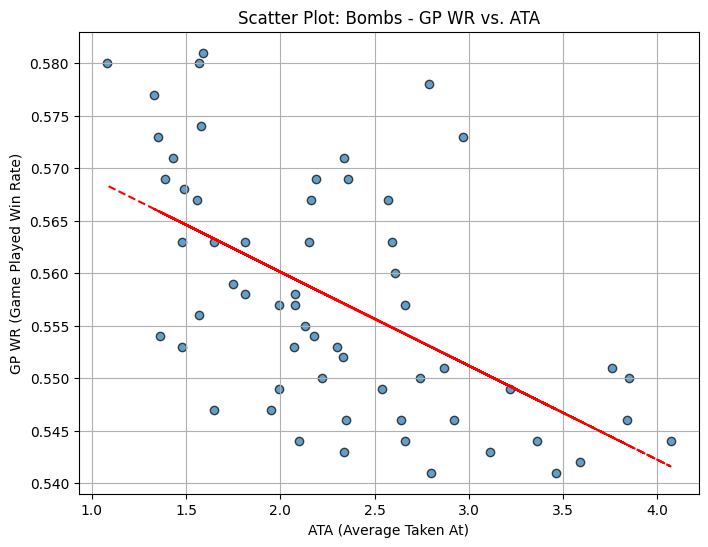

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(bombs_df["ATA"], bombs_df["GP WR"], alpha=0.7, edgecolors="black")

# Labels and title
plt.xlabel("ATA (Average Taken At)")
plt.ylabel("GP WR (Game Played Win Rate)")
plt.title("Scatter Plot: Bombs - GP WR vs. ATA")
plt.grid(True)
m, b = np.polyfit(bombs_df["ATA"], bombs_df["GP WR"], 1)
plt.plot(bombs_df["ATA"], m * bombs_df["ATA"] + b, color="red", linestyle="dashed")

# Show plot
plt.show()


In [62]:
def bomb_score_cube(bomb_table):
    """
    Calculates bomb score using [(GP WR - 0.54) * 100] ^ 3.
    """
    if bomb_table.empty:
        return 0
    return (bomb_table["count"] * (((bomb_table["GP WR"] - 0.54) * 100) ** 3)).sum()

def bomb_score_square(bomb_table):
    """
    Calculates bomb score using [(GP WR - 0.53) * 100] ^ 2.
    """
    if bomb_table.empty:
        return 0
    return (bomb_table["count"] * (((bomb_table["GP WR"] - 0.53) * 100) ** 2)).sum()


bomb_tables = get_type_stats(selected_games_df, bombs_df)

# Apply bomb score formulas to selected_games_df
selected_games_df["bomb_score_cube"] = selected_games_df["draft_id"].map(lambda draft_id: bomb_score_cube(bomb_tables.get(draft_id, pd.DataFrame())))
selected_games_df["bomb_score_square"] = selected_games_df["draft_id"].map(lambda draft_id: bomb_score_square(bomb_tables.get(draft_id, pd.DataFrame())))



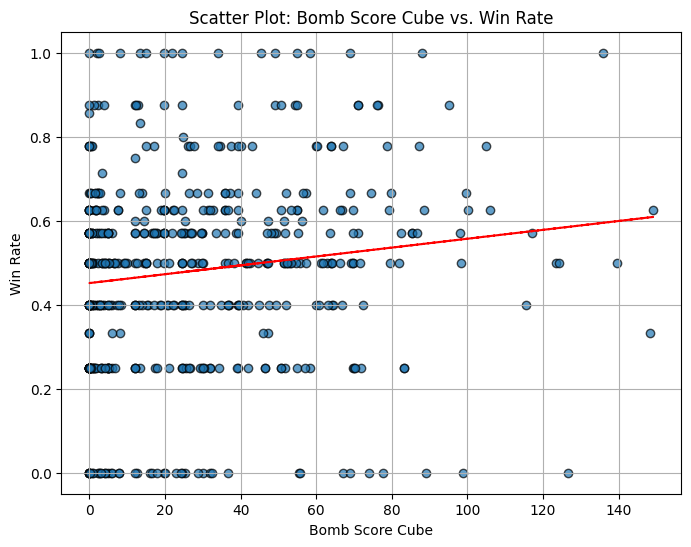

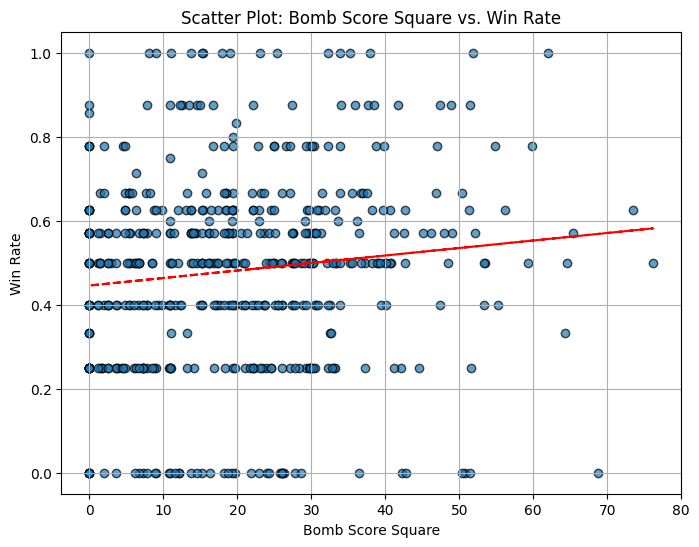

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter(df, score_col, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(df[score_col], df["win_rate"], alpha=0.7, edgecolors="black")

    # Fit linear trend line
    m, b = np.polyfit(df[score_col], df["win_rate"], 1)
    x_vals = np.array(df[score_col])
    plt.plot(x_vals, m * x_vals + b, color="red", linestyle="dashed")

    # Labels and title
    plt.xlabel(score_col.replace("_", " ").title())
    plt.ylabel("Win Rate")
    plt.title(f"Scatter Plot: {title}")
    plt.grid(True)
    plt.show()

# Generate plots for both bomb scoring methods
plot_scatter(selected_games_df, "bomb_score_cube", "Bomb Score Cube vs. Win Rate")
plot_scatter(selected_games_df, "bomb_score_square", "Bomb Score Square vs. Win Rate")


In [ ]:
# Compute Pearson correlation for bomb scores
corr_cube, p_cube = pearsonr(selected_games_df["bomb_score_cube"], selected_games_df["win_rate"])
corr_square, p_square = pearsonr(selected_games_df["bomb_score_square"], selected_games_df["win_rate"])

print(f"Pearson Correlation (Cube): {corr_cube:.4f} | P-Value: {p_cube:.4f}")
print(f"Pearson Correlation (Square): {corr_square:.4f} | P-Value: {p_square:.4f}")


Pearson Correlation (Cube): 0.1320 | P-Value: 0.0031
Pearson Correlation (Square): 0.1147 | P-Value: 0.0103


In [66]:
import pandas as pd

# Define all possible colors
color_list = ["W", "U", "B", "R", "G"]

# Create multi-hot encoded columns for colors
for color in color_list:
    selected_games_df[f"color_{color}"] = selected_games_df["main_colors"].apply(lambda x: int(color in x))

selected_games_df.head(2)

,draft_id,rank,main_colors,splash_colors,won,deck_Agate Assault,deck_Agate-Blade Assassin,deck_Alania's Pathmaker,"deck_Alania, Divergent Storm",deck_Artist's Talent,...,removal_score_53floor,removal_score_square,removal_score_53square,bomb_score_cube,bomb_score_square,color_W,color_U,color_B,color_R,color_G
0,deaa4cdcd3e84d8e8b5a0ea34a0f9d79,gold,BG,WR,1,0,0,0,0,0,...,0.088,47.72,27.12,44.017,35.47,0,0,1,0,1
9,676ca08a6f5e49ae9aee978bd62c02b1,silver,UBG,WR,1,0,0,0,0,0,...,0.053,27.05,14.45,17.999,18.73,0,1,1,0,1


In [67]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Define feature columns
features = ["bomb_score_cube", "removal_score_53floor"] + [f"color_{c}" for c in ["W", "U", "B", "R", "G"]]
X = selected_games_df[features]
y = selected_games_df["win_rate"]

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest with reasonable parameters for speed
rf_model = RandomForestRegressor(
    n_estimators=100,      # A moderate number of trees for efficiency
    max_depth=5,           # Limits depth to prevent excessive computation
    min_samples_split=10,  # Reduces overfitting, ensures splits are meaningful
    random_state=42        # Ensures reproducibility
)

# Fit the model
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error: 0.1873
R² Score: 0.0054


In [68]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Define feature columns
features = ["bomb_score_cube", "removal_score_53floor"] + [f"color_{c}" for c in ["W", "U", "B", "R", "G"]]
X = selected_games_df[features]
y = selected_games_df["win_rate"]

# Standardize features (scales both bomb and removal scores)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize XGBoost with balanced parameters
xgb_model = XGBRegressor(
    n_estimators=300,      # More trees for better learning
    max_depth=6,           # Slightly deeper than RF to capture complexity
    learning_rate=0.1,     # Default step size for reasonable convergence
    subsample=0.8,         # Reduces overfitting while maintaining performance
    colsample_bytree=0.8,  # Ensures diversity among trees
    random_state=42
)

# Fit the model
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error: 0.2171
R² Score: -0.3159


In [69]:
import numpy as np

# Print original means and standard deviations
print("Original Feature Stats:")
for feature in features:
    mean_original = np.mean(selected_games_df[feature])
    std_original = np.std(selected_games_df[feature])
    print(f"{feature}: Mean = {mean_original:.4f}, Std Dev = {std_original:.4f}")

# Print scaled means and standard deviations
print("\nScaled Feature Stats:")
scaled_means = np.mean(X_scaled, axis=0)
scaled_stds = np.std(X_scaled, axis=0)
for feature, mean_scaled, std_scaled in zip(features, scaled_means, scaled_stds):
    print(f"{feature}: Mean = {mean_scaled:.4f}, Std Dev = {std_scaled:.4f}")


Original Feature Stats:
bomb_score_cube: Mean = 28.0990, Std Dev = 29.3406
removal_score_53floor: Mean = 0.0653, Std Dev = 0.0458
color_W: Mean = 0.3760, Std Dev = 0.4844
color_U: Mean = 0.2840, Std Dev = 0.4509
color_B: Mean = 0.4880, Std Dev = 0.4999
color_R: Mean = 0.3440, Std Dev = 0.4750
color_G: Mean = 0.5480, Std Dev = 0.4977

Scaled Feature Stats:
bomb_score_cube: Mean = 0.0000, Std Dev = 1.0000
removal_score_53floor: Mean = -0.0000, Std Dev = 1.0000
color_W: Mean = -0.0000, Std Dev = 1.0000
color_U: Mean = 0.0000, Std Dev = 1.0000
color_B: Mean = 0.0000, Std Dev = 1.0000
color_R: Mean = 0.0000, Std Dev = 1.0000
color_G: Mean = -0.0000, Std Dev = 1.0000


1. Scaling issues
2. multi hot feature encoding may not be the best approach. "black" isn't necessarily great in a vacuum, but green-black is quite good.

feature engineering:

1. average winrate of cards in deck
2. synergy score
3. Curve score

In [71]:
# Count occurrences of Ygra in opening hand
opening_hand_count = games_df["opening_hand_Ygra, Eater of All"].sum()

# Count occurrences where it was ALSO drawn in the same game
drawn_after_opening_count = games_df.loc[games_df["opening_hand_Ygra, Eater of All"] > 0, "drawn_Ygra, Eater of All"].sum()

print(f"Ygra, Eater of All was in opening hand {opening_hand_count} times.")
print(f"Within those games, it was later drawn {drawn_after_opening_count} times.")


Ygra, Eater of All was in opening hand 3862 times.
Within those games, it was later drawn 92 times.


In [ ]:
from collections import Counter

# Get card names from ratings_df (excluding basics)
basic_lands = {"Plains", "Island", "Swamp", "Mountain", "Forest"}  # Modify if needed
card_names = [name for name in ratings_df["Name"] if name not in basic_lands]

# Generate "drawn_cards" as a Counter per game
selected_games_df["drawn_cards"] = selected_games_df.apply(
    lambda row: Counter({
        card: row.get(f"drawn_{card}", 0) + row.get(f"opening_hand_{card}", 0)
        for card in card_names if row.get(f"drawn_{card}", 0) > 0 or row.get(f"opening_hand_{card}", 0) > 0
    }),
    axis=1
)


0     {}
9     {}
15    {}
21    {}
27    {}
36    {}
41    {}
47    {}
56    {}
60    {}
Name: drawn_cards, dtype: object

In [77]:
def get_drawn_cards(row, card_names, basic_lands):
    """
    Extracts a list of cards that appeared in the opening hand or were drawn,
    excluding basic lands.
    
    Parameters:
    - row: A single row from the DataFrame
    - card_names: List of valid card names from ratings_df
    - basic_lands: Set of basic land names to exclude
    
    Returns:
    - List of card names appearing in the game, including duplicates
    """
    drawn_cards = []

    for card in card_names:
        if card not in basic_lands:
            drawn_count = row.get(f"drawn_{card}", 0)
            opening_count = row.get(f"opening_hand_{card}", 0)

            # Add the card multiple times if it appeared multiple times
            drawn_cards.extend([card] * (drawn_count + opening_count))

    return drawn_cards

basic_lands = {"Plains", "Island", "Swamp", "Mountain", "Forest"}
card_names = [name for name in ratings_df["Name"] if name not in basic_lands]

selected_games_df["drawn_cards"] = selected_games_df.apply(lambda row: get_drawn_cards(row, card_names, basic_lands), axis=1)


In [ ]:


# Keep only relevant columns (drawn & opening_hand)
needed_columns = [col for col in games_df.columns if col.startswith(("drawn_", "opening_hand_"))]
games_df_trimmed = games_df[needed_columns].copy()

# Apply the function to create "drawn_cards" on the reduced dataset
games_df_trimmed["drawn_cards"] = games_df_trimmed.apply(get_drawn_cards, axis=1)


KeyboardInterrupt: 

In [88]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize PySpark session
from pyspark.sql import SparkSession

print("Initializing Spark Session...")
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("MTG Synergy Analysis") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()
print("Spark Session initialized.")


# Convert Pandas DF to Spark DF (keeping only relevant columns)
spark_df = spark.createDataFrame(games_df_trimmed)

# Define function for extracting drawn cards efficiently
def extract_drawn_cards(row):
    drawn_cards = []
    basic_lands = {"Plains", "Island", "Swamp", "Mountain", "Forest"}
    
    for col, value in row.asDict().items():
        if col.startswith(("drawn_", "opening_hand_")):
            card_name = col.split("_", 1)[1]
            if card_name not in basic_lands and value > 0:
                drawn_cards.extend([card_name] * value)
    
    return drawn_cards

# Apply function in batches using PySpark map
spark_df = spark_df.withColumn("drawn_cards", col("drawn_cards").map(extract_drawn_cards))

# Convert back to Pandas if needed
games_df_trimmed = spark_df.toPandas()


Initializing Spark Session...


PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

In [89]:
import pandas as pd

batch_size = 50000
num_batches = len(games_df) // batch_size + 1  # Calculate number of batches
drawn_cards_batches = []

for i in range(num_batches):
    print(f"Processing batch {i+1} of {num_batches}...")
    batch = games_df.iloc[i * batch_size: (i + 1) * batch_size]  # Slice rows
    batch["drawn_cards"] = batch.apply(get_drawn_cards, axis=1)
    drawn_cards_batches.append(batch[["drawn_cards"]])  # Keep only needed column

# Merge all batches
games_df["drawn_cards"] = pd.concat(drawn_cards_batches).reset_index(drop=True)["drawn_cards"]


Processing batch 1 of 19...


C:\Users\aaeam\AppData\Local\Temp\ipykernel_20196\247801394.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["drawn_cards"] = batch.apply(get_drawn_cards, axis=1)


Processing batch 2 of 19...


KeyboardInterrupt: 

In [5]:
def extract_drawn_cards(row):
    drawn_cards = []
    basic_lands = {"Plains", "Island", "Swamp", "Mountain", "Forest"}
    
    for col, value in row.asDict().items():
        if col.startswith(("drawn_", "opening_hand_")):
            card_name = col.split("_", 1)[1]
            if card_name not in basic_lands and value > 0:
                drawn_cards.extend([card_name] * value)
    
    return drawn_cards

# Select relevant columns (drawn/opening_hand + game ID for merging)
needed_columns = ["draft_id"] + [col for col in games_df.columns if col.startswith(("drawn_", "opening_hand_"))]
games_df_trimmed = games_df[needed_columns].copy()

batch_size = 50000
num_batches = len(games_df_trimmed) // batch_size + 1  # Calculate number of batches
drawn_cards_batches = []

for i in range(num_batches):
    print(f"Processing batch {i+1} of {num_batches}...")
    batch = games_df_trimmed.iloc[i * batch_size: (i + 1) * batch_size].copy()  # Ensure a full copy
    batch.loc[:, "drawn_cards"] = batch.apply(extract_drawn_cards, axis=1)  # Use .loc[] for setting
    drawn_cards_batches.append(batch[["game_id", "drawn_cards"]])  # Keep only needed columns

# Merge all batches back into the full dataframe
drawn_cards_df = pd.concat(drawn_cards_batches).reset_index(drop=True)

# Merge back to games_df using game_id
games_df = games_df.merge(drawn_cards_df, on="game_id", how="left")


Processing batch 1 of 19...


AttributeError: 'Series' object has no attribute 'asDict'

In [6]:
def extract_drawn_cards(row):
    """
    Extracts a set of non-basic cards from a row in games_df_trimmed.
    - Strips "drawn_" and "opening_hand_" prefixes.
    - Keeps only unique card names (no duplicates).
    - Filters out basic lands.
    """
    basic_lands = {"Plains", "Island", "Swamp", "Mountain", "Forest"}
    drawn_cards = set()

    for col, value in row.to_dict().items():
        if col.startswith(("drawn_", "opening_hand_")):
            card_name = col.split("_", 1)[1]  # Extract actual card name
            if  value > 0 and card_name not in basic_lands:
                drawn_cards.add(card_name)  # Use a set to keep unique cards

    return drawn_cards

# Select relevant columns (drawn/opening_hand + draft_id for merging)
needed_columns = ["draft_id"] + [col for col in games_df.columns if col.startswith(("drawn_", "opening_hand_"))]
games_df_trimmed = games_df[needed_columns].copy()

batch_size = 50000
num_batches = len(games_df_trimmed) // batch_size + 1  # Calculate number of batches
drawn_cards_batches = []

for i in range(num_batches):
    print(f"Processing batch {i+1} of {num_batches}...")
    batch = games_df_trimmed.iloc[i * batch_size: (i + 1) * batch_size].copy()  # Ensure a full copy
    batch.loc[:, "drawn_cards"] = batch.apply(extract_drawn_cards, axis=1)  # Apply function row-wise
    drawn_cards_batches.append(batch[["draft_id", "drawn_cards"]])  # Keep only needed columns

# Merge all batches back into the full dataframe
drawn_cards_df = pd.concat(drawn_cards_batches).reset_index(drop=True)

# Merge back to games_df using draft_id
games_df = games_df.merge(drawn_cards_df, on="draft_id", how="left")


Processing batch 1 of 19...
Processing batch 2 of 19...
Processing batch 3 of 19...
Processing batch 4 of 19...
Processing batch 5 of 19...
Processing batch 6 of 19...
Processing batch 7 of 19...
Processing batch 8 of 19...
Processing batch 9 of 19...
Processing batch 10 of 19...
Processing batch 11 of 19...
Processing batch 12 of 19...
Processing batch 13 of 19...
Processing batch 14 of 19...
Processing batch 15 of 19...
Processing batch 16 of 19...
Processing batch 17 of 19...
Processing batch 18 of 19...
Processing batch 19 of 19...


MemoryError: Unable to allocate 63.1 GiB for an array with shape (1387, 6101996) and data type int64